# Lecture 15: Clustering class demo

![](../../img/eva-fun-times.png)

## Let's cluster images!!

For this demo, I'm going to use two image datasets: 
1. A small subset of [200 Bird Species with 11,788 Images](https://www.kaggle.com/datasets/veeralakrishna/200-bird-species-with-11788-images) dataset (available [here](../data/birds.zip))
2. A tiny subset of [Food-101](https://www.kaggle.com/datasets/kmader/food41?select=food_c101_n10099_r32x32x1.h5)
(available [here](../data/food.zip))


To run the code below, you need to install pytorch and torchvision in the course conda environment. 

```conda install pytorch torchvision -c pytorch```

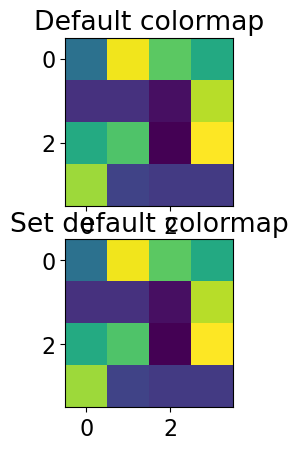

In [22]:
import os
import random
import sys
import time

import numpy as np
import pandas as pd

sys.path.append(os.path.join(os.path.abspath(".."), (".."), "code"))
from plotting_functions_unsup import *

import torch
import torchvision
from torchvision import datasets, models, transforms, utils
from PIL import Image
import matplotlib.pyplot as plt
import random

Let's start with  small subset of birds dataset. You can experiment with a bigger dataset if you like.

In [23]:
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
device

device(type='mps')

In [24]:
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

In [25]:
set_seed(seed=42)

In [26]:
import glob
IMAGE_SIZE = 224
def read_img_dataset(data_dir):     
    data_transforms = transforms.Compose(
        [
            transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),     
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),            
        ])
               
    image_dataset = datasets.ImageFolder(root=data_dir, transform=data_transforms)
    dataloader = torch.utils.data.DataLoader(
         image_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0
    )
    dataset_size = len(image_dataset)
    class_names = image_dataset.classes
    inputs, classes = next(iter(dataloader))
    return inputs, classes

In [27]:
def plot_sample_imgs(inputs):
    plt.figure(figsize=(10, 70)); plt.axis("off"); plt.title("Sample Training Images")
    plt.imshow(np.transpose(utils.make_grid(inputs, padding=1, normalize=True),(1, 2, 0)));

In [28]:
data_dir = "../../data/birds"
file_names = [image_file for image_file in glob.glob(data_dir + "/*/*.jpg")]
n_images = len(file_names)
BATCH_SIZE = n_images  # because our dataset is quite small
birds_inputs, birds_classes = read_img_dataset(data_dir)

In [29]:
X_birds = birds_inputs.numpy()

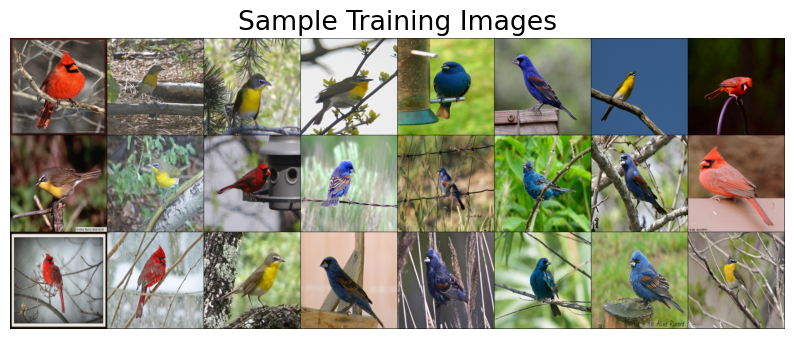

In [30]:
plot_sample_imgs(birds_inputs[0:24,:,:,:])
plt.show()

For clustering we need to calculate distances between points. So we need a vector representation for each data point. A simplest way to create a vector representation of an image is by flattening the image.  

In [31]:
flatten_transforms = transforms.Compose([    
                    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                    transforms.ToTensor(),
                    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),    
                    transforms.Lambda(torch.flatten)])
flatten_images = datasets.ImageFolder(root='../../data/birds', transform=flatten_transforms)

In [32]:
flatten_dataloader = torch.utils.data.DataLoader(
        flatten_images, batch_size=BATCH_SIZE, shuffle=True, num_workers=0
    )

In [33]:
flatten_train, y_train = next(iter(flatten_dataloader))

In [34]:
flatten_images = flatten_train.numpy()

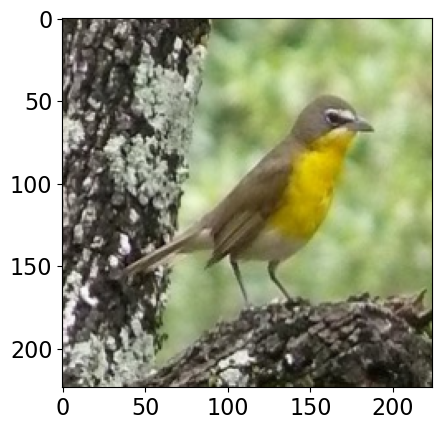

In [35]:
image_shape=[3,224,224]
img = flatten_images[20].reshape(image_shape)
plt.imshow(np.transpose(img / 2 + 0.5, (1, 2, 0)));

In [36]:
flatten_images.shape # 224 by 224 images with 3 color channels

(176, 150528)

In [37]:
from sklearn.cluster import KMeans
k = 3
km_flatten = KMeans(k, n_init='auto', random_state=123)
km_flatten.fit(flatten_images)

KMeans(n_clusters=3, random_state=123)

In [38]:
km_flatten.cluster_centers_.shape

(3, 150528)

In [39]:
flatten_images.shape

(176, 150528)

In [40]:
unflatten_inputs = np.array([img.reshape(image_shape) for img in flatten_images])

158
Image indices:  [158  65  48 125  95]


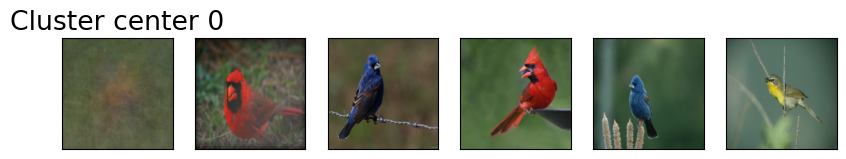

165
Image indices:  [165  94  77 152 108]


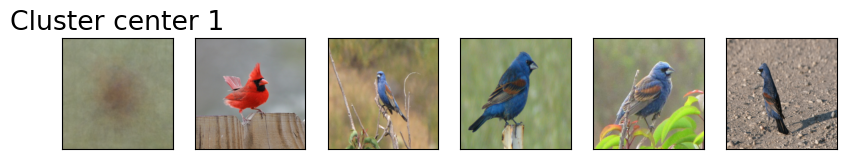

156
Image indices:  [156  89 100  25 133]


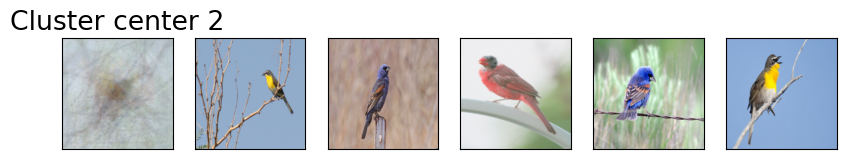

In [41]:
for cluster in range(k):
    # user-defined functions defined in ../code/plotting_functions.py
    get_cluster_images(km_flatten, flatten_images, unflatten_inputs, cluster, n_img=5)

We still see some mis-categorizations. It seems like when we flatten images, clustering doesn't seem that great.  

How about trying out a different input representation? Let's use transfer learning as a feature extractor with a pre-trained vision model. For each image in our dataset we'll pass it through a pretrained network and get a representation from the last layer, before the classification layer given by the pre-trained network. 

![](../../img/cnn-ex.png)

Source: https://cezannec.github.io/Convolutional_Neural_Networks/

In [44]:
def get_features(model, inputs):
    """Extract output of densenet model"""
    model.eval()
    with torch.no_grad():  # turn off computational graph stuff        
        Z = model(inputs).detach().numpy()         
    return Z

In [45]:
densenet = models.densenet121(weights="DenseNet121_Weights.IMAGENET1K_V1")
densenet.classifier = torch.nn.Identity()  # remove that last "classification" layer
Z_birds = get_features(densenet, birds_inputs)

In [46]:
Z_birds.shape

(176, 1024)

Do we get better clustering with this representation? 

In [47]:
from sklearn.cluster import KMeans

k = 3
km = KMeans(n_clusters=k, n_init='auto', random_state=123)
km.fit(Z_birds)

KMeans(n_clusters=3, random_state=123)

In [48]:
km.cluster_centers_.shape

(3, 1024)

103
Image indices:  [103  23  86 162 168 122]


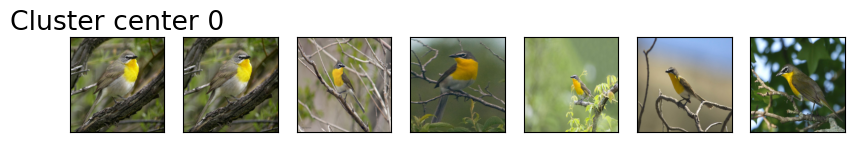

55
Image indices:  [55 31 53 15 88 84]


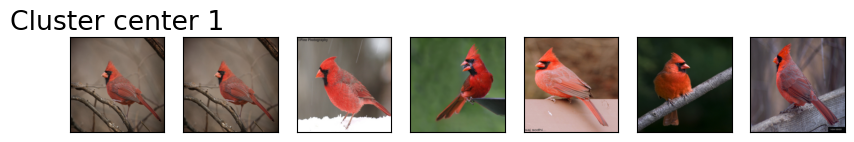

120
Image indices:  [120   5  11  14  22  69]


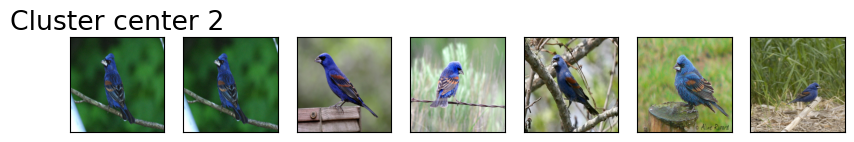

In [49]:
for cluster in range(k):
    # user-defined functions defined in ../code/plotting_functions.py
    get_cluster_images(km, Z_birds, X_birds, cluster, n_img=6)

Cool! KMeans seems to be doing a good job with this representation. 

This dataset seems easier, as the birds have very distinct colors. Let's try a bit more complicated dataset.  

In [54]:
data_dir = "../../data/food"
file_names = [image_file for image_file in glob.glob(data_dir + "/*/*.jpg")]
n_images = len(file_names)
BATCH_SIZE = n_images  # because our dataset is quite small
food_inputs, food_classes = read_img_dataset(data_dir)
n_images

350

In [55]:
X_food = food_inputs.numpy()

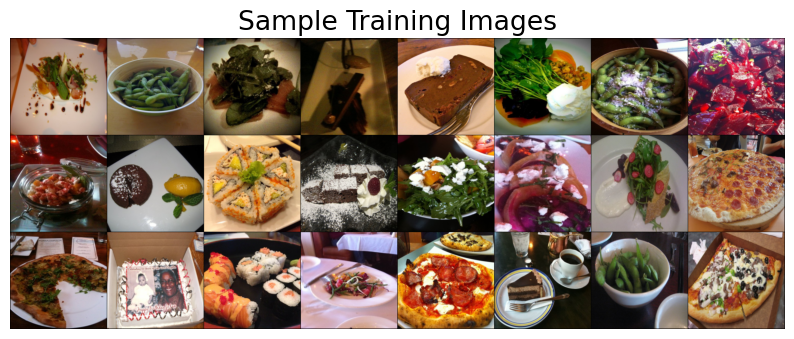

In [56]:
plot_sample_imgs(food_inputs[0:24,:,:,:])

In [57]:
Z_food = get_features(
    densenet, food_inputs, 
)

In [58]:
Z_food.shape

(350, 1024)

In [59]:
from sklearn.cluster import KMeans

k = 5
km = KMeans(n_clusters=k, n_init='auto', random_state=123)
km.fit(Z_food)

KMeans(n_clusters=5, random_state=123)

In [60]:
km.cluster_centers_.shape

(5, 1024)

84
Image indices:  [ 84 169 328   0 143  12]


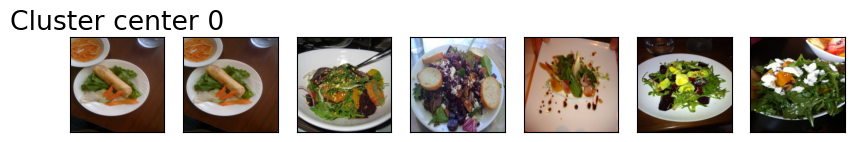

263
Image indices:  [263  80 257 301  44 326]


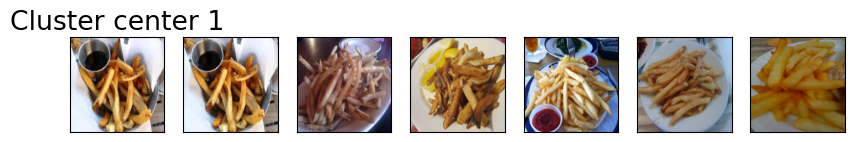

188
Image indices:  [188   1 339 273  55 238]


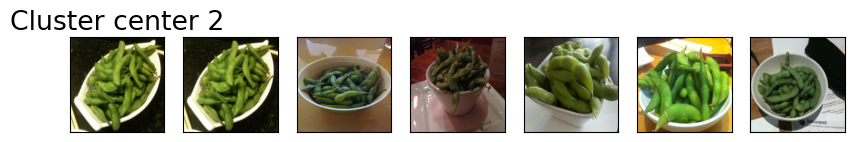

282
Image indices:  [282 150 177 138 116 123]


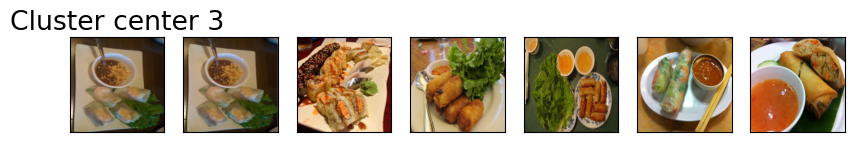

20
Image indices:  [ 20  39 332  15 226 322]


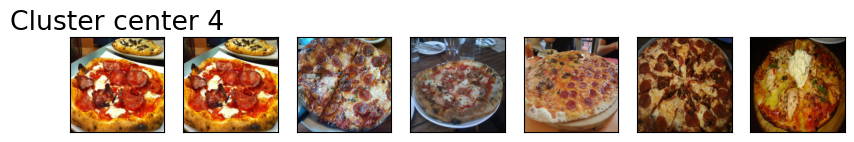

In [61]:
for cluster in range(k):
    get_cluster_images(km, Z_food, X_food, cluster, n_img=6)

There are some mis-classifications but overall it seems pretty good! You can experiment with 
- Different values for number of clusters
- Different pre-trained models
- Other possible representations 
- Different image datasets